In [51]:
import os
import PIL
## checking for xrays and their respective masks
from glob import glob
import re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from skimage import measure

DIR = "C:/Users/jaejiniida/Desktop/nested_unet_model(working)"

image_path = glob(os.path.join(DIR, 'second_images/*.png'))
mask_path = glob(os.path.join(DIR, 'second_mask/*.png'))

related_paths = defaultdict(list)

for img, mask in zip(image_path, mask_path) :
    related_paths['image_path'].append(img)
    related_paths['mask_path'].append(mask)
            
paths_df = pd.DataFrame.from_dict(related_paths)

In [64]:
from tqdm import tqdm
import cv2
def prepare_train_test(df = pd.DataFrame(), resize_shape = tuple(), color_mode = "rgb"):
    img_array = list()
    mask_array = list()

    for image_path in tqdm(paths_df.image_path):
        resized_image = cv2.resize(cv2.imread(image_path),resize_shape)
        resized_image = resized_image/255.
        if color_mode == "gray":
            img_array.append(resized_image[:,:,0])
        elif color_mode == "rgb":
            img_array.append(resized_image[:,:,:])
      # img_array.append(resized_image)
  
    for mask_path in tqdm(paths_df.mask_path):
        resized_mask = cv2.resize(cv2.imread(mask_path),resize_shape)
        resized_mask = resized_mask/255.
        mask_array.append(resized_mask[:,:,0])
        # mask_array.append(resized_image)

    return img_array, mask_array

img_array, mask_array = prepare_train_test(df = paths_df, resize_shape = (256,256), color_mode = "rgb")
print(len(img_array), len(mask_array))
print(img_array[0].shape, mask_array[0].shape)

100%|██████████| 1192/1192 [00:21<00:00, 55.15it/s] 

1192 1192
(256, 256, 3) (256, 256)


In [65]:
from sklearn.model_selection import train_test_split
img_train, img_test, mask_train, mask_test = train_test_split(img_array, mask_array, test_size = 0.2, random_state= 42)


# convert them all into numpy arrays.
img_side_size = 256
img_train = np.array(img_train).reshape(len(img_train), img_side_size, img_side_size, 3) # should be modified for grayscale images
img_test = np.array(img_test).reshape(len(img_test), img_side_size, img_side_size, 3)
mask_train = np.array(mask_train).reshape(len(mask_train), img_side_size, img_side_size)
mask_test = np.array(mask_test).reshape(len(mask_test), img_side_size, img_side_size)

In [67]:
# U-net network

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.activations import *


def dice_coef(y_true, y_pred) :
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred) :
    return -dice_coef(y_true, y_pred)

def unet(input_size = (256, 256, 1)) :
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(inputs) #(254, 254, 32)
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv1)
    
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation= 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv2)
    
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv3)
    
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
    
    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv4)
    
    pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)
    
    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv5)
    
    #upsampling (decoder part)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides = (2,2), padding = 'same')(conv5), conv4], axis = 3)
    conv6 = Conv2D(256, (3, 3), activation= 'relu', padding = 'same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding ='same')(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides = (2,2), padding = 'same')(conv6), conv3], axis = 3)
    conv7 = Conv2D(128, (3, 3), activation= 'relu', padding = 'same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding ='same')(conv7)
    
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides = (2, 2), padding='same')(conv7), conv2], axis = 3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2,2), strides = (2,2),padding='same')(conv8), conv1], axis = 3)
    conv9 = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(up9)
    conv9 = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(conv9)
    
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    
    return Model(inputs=[inputs], outputs=[conv10])
    
    


    
    

In [68]:
EPOCHS = 10
model = unet(input_size = (256, 256, 3))
model.compile(optimizer = Adam(learning_rate=5*1e-4), loss = 'binary_crossentropy', \
    metrics = [dice_coef, 'binary_accuracy'])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_149 (Conv2D)            (None, 256, 256, 32  896         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_150 (Conv2D)            (None, 256, 256, 32  9248        ['conv2d_149[0][0]']             
                                )                                                           

In [69]:
tf.keras.utils.plot_model(model, to_file='./model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [70]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='loss', #verbose=1, 
                             save_best_only=True, #mode='min', 
                             save_weights_only = True)


early = EarlyStopping(monitor="loss", 
                      #mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early]

In [71]:

history = model.fit(x = img_train, 
                    y = mask_train, 
                    validation_data = (img_test, mask_test), 
                    epochs = 30, 
                    batch_size = 16,
                   callbacks = callbacks_list)
model.save('my_model.h5')

Epoch 1/30
60/60 [==============================] - 708s 12s/step - loss: 0.2383 - dice_coef: 0.0806 - binary_accuracy: 0.9246 - val_loss: 0.1106 - val_dice_coef: 0.2029 - val_binary_accuracy: 0.9459
Epoch 2/30
60/60 [==============================] - 699s 12s/step - loss: 0.0814 - dice_coef: 0.3561 - binary_accuracy: 0.9494 - val_loss: 0.0586 - val_dice_coef: 0.4938 - val_binary_accuracy: 0.9622
Epoch 3/30
60/60 [==============================] - 696s 12s/step - loss: 0.0427 - dice_coef: 0.6633 - binary_accuracy: 0.9700 - val_loss: 0.0339 - val_dice_coef: 0.7667 - val_binary_accuracy: 0.9703
Epoch 4/30
60/60 [==============================] - 698s 12s/step - loss: 0.0267 - dice_coef: 0.8056 - binary_accuracy: 0.9752 - val_loss: 0.0236 - val_dice_coef: 0.8367 - val_binary_accuracy: 0.9738
Epoch 5/30
60/60 [==============================] - 695s 12s/step - loss: 0.0204 - dice_coef: 0.8552 - binary_accuracy: 0.9771 - val_loss: 0.0188 - val_dice_coef: 0.8740 - val_binary_accuracy: 0.9752


1/1 [==============================] - 0s 129ms/step


0.9634359339234233

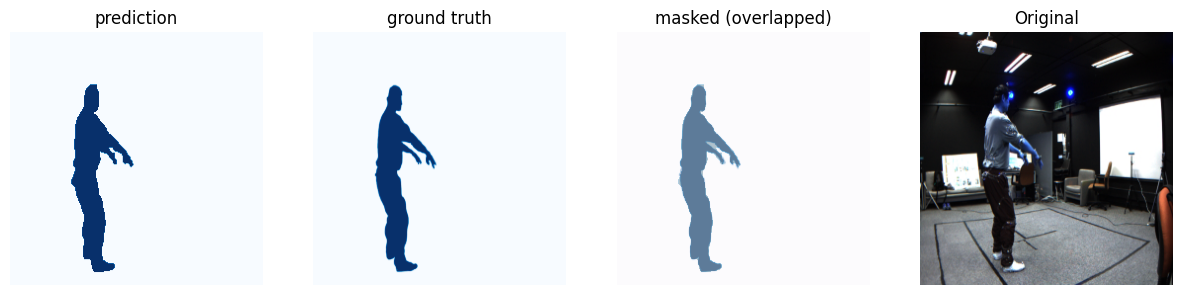

In [77]:
def test_on_image(model, img_array, img_num, img_side_size = 256):
    
    pred = model.predict(img_array[img_num].reshape(1,img_side_size,img_side_size,3))
    pred[pred>0.5] = 1.0
    pred[pred<0.5] = 0.0
    fig = plt.figure(figsize = (15,10))
    
    plt.subplot(1,4,1)
    plt.imshow(pred.reshape(img_side_size, img_side_size), cmap = "Blues")
    plt.title("prediction")
    plt.axis("off")
    
    plt.subplot(1,4,2)
    plt.imshow(mask_test[img_num].reshape(img_side_size, img_side_size), cmap = "Blues")
    plt.title("ground truth");
    plt.axis("off")
    
    plt.subplot(1,4,3)
    plt.imshow(mask_test[img_num].reshape(img_side_size, img_side_size), cmap = "Blues", alpha = 0.5)
    plt.imshow(pred.reshape(img_side_size, img_side_size),cmap = "PuBu", alpha = 0.3)
    plt.title("masked (overlapped)")
    plt.axis("off")
    
    plt.subplot(1,4,4)
    plt.imshow(img_array[img_num].reshape(img_side_size, img_side_size, 3))
    plt.title("Original")
    plt.axis("off")
    
    return pred

def dice_coef_test(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

import random
IMG_NUM = random.randint(0, 101) #Melhor img_num 12 (0.98) Pior img_num 10 (0.9)
prediction = test_on_image(model, img_array = img_test, img_num = IMG_NUM, img_side_size = 256)
dice_coef_test(y_true = mask_test[IMG_NUM], y_pred = prediction)